In [1]:
random_state = 35

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras import utils
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm
import os
import random

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

In [3]:
# Set path for data source
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
weather = pd.read_csv('weather.csv')
metadata = pd.read_csv('metadata.csv')

In [5]:
df_meter = []
df_meta = []

for meter_data_cleand in os.listdir():
    if meter_data_cleand.endswith('_cleaned.csv'):
        meter_type = meter_data_cleand.split('_cleaned.csv')[0]
        df_meter_data_cleand = pd.read_csv(meter_data_cleand, index_col='timestamp')

        df_meta_cleand = metadata.set_index('building_id').loc[df_meter_data_cleand.columns]
        df_meta.append(df_meta_cleand)

        df_meter_data_cleand.columns = meter_type+'_'+df_meter_data_cleand.columns
        df_meter.append(df_meter_data_cleand)

df_meter = pd.concat(df_meter, axis=1)

df_meta = pd.concat(df_meta, axis=0)
df_meta = df_meta.reset_index().rename(columns={'index':'building_id'})
df_meta.index = df_meter.columns

In [6]:
data_availability = ~df_meter.isna()
data_availability.index = pd.to_datetime(data_availability.index)
data_availability = data_availability.resample('Y').mean()
data_availability.mean(axis=1)

timestamp
2016-12-31    0.892000
2017-12-31    0.933236
Freq: A-DEC, dtype: float64

In [7]:
df_meta.loc[df_meta['lat'].isna(),'lat'] = df_meta.groupby('timezone')['lat'].transform('mean').loc[df_meta['lat'].isna()]
df_meta.loc[df_meta['lng'].isna(),'lng'] = df_meta.groupby('timezone')['lng'].transform('mean').loc[df_meta['lng'].isna()]
df_meta['meter'] = df_meta.index.str.split('_',expand=True).get_level_values(0)
df_meta['primary_use'] = df_meta.index.str.split('_',expand=True).get_level_values(2)

In [8]:
df_meter = df_meter.loc[:, df_meter.isna().mean()<0.05]
df_meta = df_meta.loc[df_meter.columns]

In [9]:
df_meter

,chilledwater_Fox_lodging_Stephen,chilledwater_Fox_lodging_Stephan,chilledwater_Fox_office_Israel,chilledwater_Fox_education_Lilly,chilledwater_Fox_education_Gayla,chilledwater_Fox_lodging_Warren,chilledwater_Fox_education_Andre,chilledwater_Fox_retail_Manie,chilledwater_Fox_assembly_Emma,chilledwater_Fox_office_Margarita,...,water_Wolf_education_Loren,water_Wolf_education_Roderick,water_Wolf_education_Josefa,water_Wolf_education_Dorris,water_Wolf_retail_Toshia,water_Wolf_retail_Harriett,water_Wolf_office_Bobbie,water_Wolf_education_Miguel,water_Wolf_assembly_Elaine,water_Wolf_education_Ursula
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0000,18.7997,0.0000,98.8221,291.5194,0.0,181.3182,39.7021,175.3814,21.6445,...,63.4013,0.0,2.6417,0.0,0.0000,3.9626,5.2834,31.7006,96.9511,44.9092
2016-01-01 01:00:00,0.0000,19.0469,0.0000,100.9248,270.2460,0.0,279.5221,33.3942,187.8736,20.9024,...,63.4013,0.0,1.3209,0.0,0.0000,5.2834,7.9252,34.3424,96.4228,42.2675
2016-01-01 02:00:00,0.0000,19.4183,0.0000,101.2958,258.2486,0.0,271.6063,31.7863,185.8947,19.7893,...,68.6847,0.0,2.6417,0.0,0.0000,3.9626,10.5669,31.7006,96.6870,44.9092
2016-01-01 03:00:00,0.0000,20.6548,0.0000,105.2537,241.1806,0.0,133.2060,29.6836,182.8023,19.1707,...,60.7596,0.0,2.6417,0.0,0.0000,3.9626,13.2086,200.7707,96.4228,44.9092
2016-01-01 04:00:00,0.0000,21.0258,0.0000,99.4407,248.7253,0.0,157.2004,30.1784,183.2972,18.5524,...,68.6847,0.0,1.3209,0.0,0.0000,3.9626,10.5669,31.7006,97.4795,44.9092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,11.1315,0.1238,16.9445,0.0000,0.0000,0.0,925.1440,32.2812,1241.5233,0.0000,...,50.1927,0.0,0.0000,0.0,10.5669,7.9252,31.7006,0.0000,0.7925,55.4761
2017-12-31 20:00:00,44.6492,0.0000,13.9760,0.0000,0.0000,0.0,925.1440,16.0787,1132.6828,0.0000,...,76.6099,0.0,0.0000,0.0,10.5669,6.6043,29.0589,0.0000,0.0000,50.1927
2017-12-31 21:00:00,18.6759,2.1027,11.1315,0.0000,0.0000,0.0,925.1440,5.9368,998.6113,0.0000,...,44.9092,0.0,0.0000,0.0,10.5669,6.6043,26.4172,0.0000,0.0000,52.8344


In [10]:
df_meta['meter'].value_counts()

electricity     1019
chilledwater     398
steam            246
gas              161
hotwater         152
water            119
irrigation        11
solar              4
Name: meter, dtype: int64

In [11]:
df_meta = df_meta[df_meta.groupby(['primaryspaceusage'])['building_id'].transform('count')>100]
df_meta = df_meta[df_meta.groupby(['meter'])['building_id'].transform('count')>100]
df_meter = df_meter.loc[:, df_meta.index]

df_meta['meter'].value_counts()

electricity     933
chilledwater    377
steam           224
gas             151
hotwater        143
Name: meter, dtype: int64

In [12]:
train_data = df_meter.fillna(method='ffill').fillna(method='bfill')

train_data = train_data.iloc[:168*52]
train_data = (train_data-train_data.min())/(train_data.max()-train_data.min())
train_data = (train_data-0.5)*2
train_data = train_data.dropna(axis=1, how='all')
test_data = train_data.sample(frac=0.25, random_state=random_state, axis=1)
train_data = train_data.drop(test_data.columns, axis=1)

train_data = train_data.sample(frac=1, axis=1, random_state=random_state)#shuffle meters

X_train = train_data.T.to_numpy()#.reshape(train_data.shape[1], 52, 168)
#X_train = X_train[:,:52,:]

X_test = test_data.T.to_numpy()#.reshape(test_data.shape[1], 52, 168)
#X_test = X_test[:,:52,:]

In [13]:
#X_train = np.expand_dims(X_train, axis=2)
#X_train = tf.image.resize(X_train, [img_rows, img_cols]).numpy()
X_train.shape

(1354, 8736)

In [14]:
#X_test = np.expand_dims(X_test, axis=2)
#X_test = tf.image.resize(X_test, [img_rows, img_cols]).numpy()
X_test.shape

(451, 8736)

In [15]:
metadata = df_meta.copy()
metadata['meter'] = metadata.index.str.split('_',expand=True).get_level_values(0)

def encode_str_columns(df):
    encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df.loc[:, column] = encoder.fit_transform(df[column])
    return df

metadata = encode_str_columns(metadata)

#metadata = (metadata-metadata.min())/(metadata.max()-metadata.min())
#metadata = (metadata-0.5)*2
metadata

<ipython-input-15-ffd7adaa6fa7>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, column] = encoder.fit_transform(df[column])
<ipython-input-15-ffd7adaa6fa7>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, column] = encoder.fit_transform(df[column])
<ipython-input-15-ffd7adaa6fa7>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,...,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating,meter,primary_use
chilledwater_Fox_lodging_Stephen,382,4,167.0,2.0,2,10,8019.7,86323.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,2
chilledwater_Fox_lodging_Stephan,381,4,215.0,2.0,2,10,3382.2,36406.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,2
chilledwater_Fox_office_Israel,397,4,172.0,2.0,3,24,11282.1,121440.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,3
chilledwater_Fox_education_Lilly,345,4,250.0,2.0,0,6,12236.3,131710.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,1
chilledwater_Fox_education_Gayla,330,4,191.0,2.0,0,5,7271.3,78268.0,33.424425,-111.92814,...,NaN,NaN,27,140,120,120,3,9,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
steam_Eagle_lodging_Casey,244,3,1307.0,14.0,2,18,6132.8,66013.0,37.406733,-77.80613,...,NaN,NaN,27,140,120,120,3,9,4,2
steam_Eagle_office_Tia,284,3,1225.0,14.0,3,24,11403.5,122746.0,37.406733,-77.80613,...,NaN,NaN,27,140,120,120,3,9,4,3
steam_Eagle_office_Remedios,280,3,1293.0,14.0,3,24,4781.8,51471.0,37.406733,-77.80613,...,NaN,NaN,27,140,120,120,3,9,4,3
steam_Eagle_office_Patrice,277,3,1238.0,14.0,3,24,12050.2,129707.0,37.406733,-77.80613,...,NaN,NaN,27,140,120,120,3,9,4,3


In [16]:
Y_train = metadata.loc[train_data.columns, 'meter']
Y_train = Y_train.values
Y_train.shape

(1354,)

In [17]:
Y_test = metadata.loc[test_data.columns, 'meter']
Y_test = Y_test.values
Y_test.shape

(451,)

In [18]:
# Function to create FCN model
def create_fcn_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # 5 classes for multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to create 1D-CNN model
def create_1d_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # 5 classes for multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to create 2D-CNN model
def create_2d_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # 5 classes for multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
# Create a list to store the results
results = []

# Lists to store F1 scores
fcn_f1_scores, cnn_1d_f1_scores, cnn_2d_f1_scores, ls_f1_scores, lp_f1_scores = [], [], [], [], []

# Define the sample sizes to be tested
sample_sizes = list(range(100, 1355, 100))

# Define the number of epochs and early stopping parameters
epochs = 500
patience = 50

# Iterate over each sample size
for size in tqdm(sample_sizes, desc="Sample Size"):
    # Select a subset of data for training
    X_train_subset = X_train[:size]
    Y_train_subset = Y_train[:size]

    # Reshape the data for 1D-CNN and 2D-CNN
    X_train_1d_cnn = np.reshape(X_train_subset, (size, X_train.shape[1], 1))
    X_train_2d_cnn = np.reshape(X_train_subset, (size, 168, 52, 1))

    # Create and train the models with early stopping
    fcn_model = create_fcn_model((X_train_subset.shape[1],))
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    fcn_model.fit(X_train_subset, Y_train_subset, epochs=epochs, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

    cnn_1d_model = create_1d_cnn_model((X_train.shape[1], 1))
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    cnn_1d_model.fit(X_train_1d_cnn, Y_train_subset, epochs=epochs, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

    cnn_2d_model = create_2d_cnn_model((168, 52, 1))
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    cnn_2d_model.fit(X_train_2d_cnn, Y_train_subset, epochs=epochs, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

    # Evaluate the models on the test dataset
    fcn_accuracy = fcn_model.evaluate(X_test, Y_test, verbose=0)[1]

    X_test_1d_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    cnn_1d_accuracy = cnn_1d_model.evaluate(X_test_1d_cnn, Y_test, verbose=0)[1]

    X_test_2d_cnn = np.reshape(X_test, (X_test.shape[0], 168, 52, 1))
    cnn_2d_accuracy = cnn_2d_model.evaluate(X_test_2d_cnn, Y_test, verbose=0)[1]

    # We'll use these labels to mark samples that are unlabeled
    labels = np.copy(Y_train_subset)
    rng = np.random.RandomState(42)
    random_unlabeled_points = rng.rand(len(Y_train_subset)) < 0.5
    labels[random_unlabeled_points] = -1

    # Create and train the Label Spreading model
    ls_model = LabelSpreading(kernel='knn', alpha=0.8, max_iter=200)
    ls_model.fit(X_train_subset, labels)
    # Evaluate the model on the test dataset
    y_pred = ls_model.predict(X_test)
    ls_accuracy = accuracy_score(Y_test, y_pred)

    # Create and train the Label Propagation model
    lp_model = LabelPropagation(kernel='knn', max_iter=200)
    lp_model.fit(X_train_subset, labels)
    # Evaluate the model on the test dataset
    y_pred = lp_model.predict(X_test)
    lp_accuracy = accuracy_score(Y_test, y_pred)

    results.append((size, fcn_accuracy, cnn_1d_accuracy, cnn_2d_accuracy, ls_accuracy, lp_accuracy))

    # Predictions
    y_pred_fcn = np.argmax(fcn_model.predict(X_test), axis=1)
    y_pred_cnn_1d = np.argmax(cnn_1d_model.predict(X_test_1d_cnn), axis=1)
    y_pred_cnn_2d = np.argmax(cnn_2d_model.predict(X_test_2d_cnn), axis=1)

    # True labels
    y_true = Y_test

    # F1 Score Calculations
    fcn_f1_score_macro = f1_score(y_true, y_pred_fcn, average='macro')
    cnn_1d_f1_score_macro = f1_score(y_true, y_pred_cnn_1d, average='macro')
    cnn_2d_f1_score_macro = f1_score(y_true, y_pred_cnn_2d, average='macro')
    ls_f1_score_macro = f1_score(y_true, ls_model.predict(X_test), average='macro')
    lp_f1_score_macro = f1_score(y_true, lp_model.predict(X_test), average='macro')

    # Append to lists
    fcn_f1_scores.append(fcn_f1_score_macro)
    cnn_1d_f1_scores.append(cnn_1d_f1_score_macro)
    cnn_2d_f1_scores.append(cnn_2d_f1_score_macro)
    ls_f1_scores.append(ls_f1_score_macro)
    lp_f1_scores.append(lp_f1_score_macro)

# Separate the results into individual lists
sample_sizes, fcn_accuracies, cnn_1d_accuracies, cnn_2d_accuracies, ls_accuracies, lp_accuracies = zip(*results)



Sample Size:   0%|          | 0/13 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step


Sample Size:   8%|▊         | 1/13 [00:57<11:29, 57.42s/it]

15/15 [==============================] - 0s 2ms/step


Sample Size:  15%|█▌        | 2/13 [02:50<16:33, 90.30s/it]

15/15 [==============================] - 0s 3ms/step


Sample Size:  23%|██▎       | 3/13 [04:41<16:34, 99.46s/it]

15/15 [==============================] - 0s 3ms/step


Sample Size:  31%|███       | 4/13 [08:28<22:29, 149.96s/it]

15/15 [==============================] - 0s 3ms/step


Sample Size:  38%|███▊      | 5/13 [12:16<23:44, 178.04s/it]

15/15 [==============================] - 0s 3ms/step


Sample Size:  46%|████▌     | 6/13 [14:36<19:15, 165.10s/it]

15/15 [==============================] - 0s 4ms/step


Sample Size:  54%|█████▍    | 7/13 [19:38<20:59, 209.97s/it]

15/15 [==============================] - 0s 3ms/step


Sample Size:  62%|██████▏   | 8/13 [25:41<21:32, 258.52s/it]

15/15 [==============================] - 0s 3ms/step


Sample Size:  69%|██████▉   | 9/13 [32:43<20:39, 309.81s/it]

15/15 [==============================] - 0s 3ms/step


Sample Size:  77%|███████▋  | 10/13 [37:42<15:19, 306.43s/it]

15/15 [==============================] - 0s 3ms/step


Sample Size:  85%|████████▍ | 11/13 [44:51<11:28, 344.06s/it]

15/15 [==============================] - 0s 5ms/step


Sample Size:  92%|█████████▏| 12/13 [48:48<05:11, 311.30s/it]

15/15 [==============================] - 0s 4ms/step


Sample Size: 100%|██████████| 13/13 [55:48<00:00, 257.60s/it]


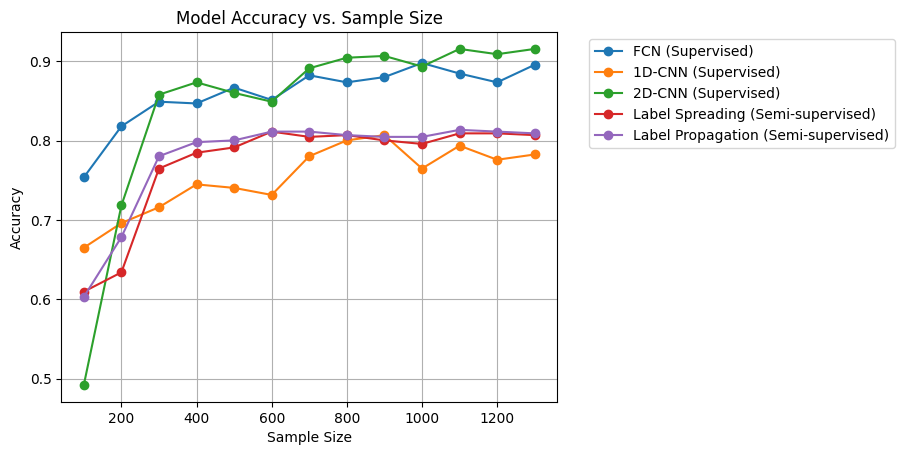

In [20]:
# Plot the accuracies for each model using line plots
plt.plot(sample_sizes, fcn_accuracies, label="FCN (Supervised)", marker='o')
plt.plot(sample_sizes, cnn_1d_accuracies, label="1D-CNN (Supervised)", marker='o')
plt.plot(sample_sizes, cnn_2d_accuracies, label="2D-CNN (Supervised)", marker='o')
plt.plot(sample_sizes, ls_accuracies, label="Label Spreading (Semi-supervised)", marker='o')
plt.plot(sample_sizes, lp_accuracies, label="Label Propagation (Semi-supervised)", marker='o')

plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Sample Size")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

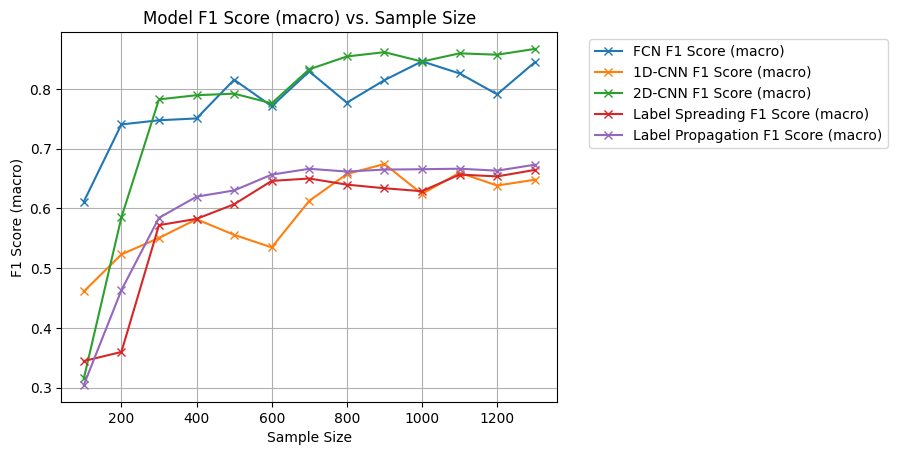

In [21]:
# Add additional plot for F1 scores
plt.plot(sample_sizes, fcn_f1_scores, label="FCN F1 Score (macro)", marker='x')
plt.plot(sample_sizes, cnn_1d_f1_scores, label="1D-CNN F1 Score (macro)", marker='x')
plt.plot(sample_sizes, cnn_2d_f1_scores, label="2D-CNN F1 Score (macro)", marker='x')
plt.plot(sample_sizes, ls_f1_scores, label="Label Spreading F1 Score (macro)", marker='x')
plt.plot(sample_sizes, lp_f1_scores, label="Label Propagation F1 Score (macro)", marker='x')

plt.xlabel("Sample Size")
plt.ylabel("F1 Score (macro)")
plt.title("Model F1 Score (macro) vs. Sample Size")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [22]:
import pandas as pd

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Sample_Size': sample_sizes,
    'FCN_Accuracy': fcn_accuracies,
    '1D_CNN_Accuracy': cnn_1d_accuracies,
    '2D_CNN_Accuracy': cnn_2d_accuracies,
    'Label_Spreading_Accuracy': ls_accuracies,
    'Label_Propagation_Accuracy': lp_accuracies,
    'FCN_F1_Score_Macro': fcn_f1_scores,
    '1D_CNN_F1_Score_Macro': cnn_1d_f1_scores,
    '2D_CNN_F1_Score_Macro': cnn_2d_f1_scores,
    'Label_Spreading_F1_Score_Macro': ls_f1_scores,
    'Label_Propagation_F1_Score_Macro': lp_f1_scores
})

# Display the DataFrame
results_df


,Sample_Size,FCN_Accuracy,1D_CNN_Accuracy,2D_CNN_Accuracy,Label_Spreading_Accuracy,Label_Propagation_Accuracy,FCN_F1_Score_Macro,1D_CNN_F1_Score_Macro,2D_CNN_F1_Score_Macro,Label_Spreading_F1_Score_Macro,Label_Propagation_F1_Score_Macro
0,100,0.753880,0.665188,0.492239,0.609756,0.603104,0.611453,0.460999,0.315365,0.344430,0.304468
1,200,0.818182,0.696231,0.718404,0.634146,0.678492,0.740699,0.523010,0.584972,0.359670,0.463153
2,300,0.849224,0.716186,0.858093,0.764967,0.780488,0.747676,0.550590,0.782687,0.572030,0.584288
3,400,0.847007,0.745011,0.873614,0.784922,0.798226,0.750730,0.581885,0.789608,0.582543,0.619708
4,500,0.866962,0.740577,0.860310,0.791574,0.800443,0.815597,0.555790,0.792250,0.606976,0.630192
5,600,0.851441,0.731707,0.849224,0.811530,0.811530,0.771138,0.534778,0.776125,0.646129,0.656643
6,700,0.882483,0.780488,0.891353,0.804878,0.811530,0.829453,0.612808,0.833060,0.650127,0.666409
7,800,0.873614,0.800443,0.904656,0.807095,0.807095,0.777163,0.657545,0.854527,0.639878,0.661789
8,900,0.880266,0.807095,0.906874,0.800443,0.804878,0.814872,0.674431,0.861715,0.633843,0.665107
9,1000,0.898004,0.764967,0.893570,0.796009,0.804878,0.846337,0.624341,0.845974,0.628881,0.665680


In [23]:
results_df.to_csv('/content/gdrive/My Drive/SGAN/baseline.csv', index=False)